In [ ]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import copy
import os

from collections import defaultdict
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from scipy.stats import describe, kstest, mannwhitneyu, sem
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis import plot, util

In [ ]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 14})

In [ ]:
"""Set torch device."""

# device = t.device("cpu")  # small toy models may be faster via cpu
device = t.device("cuda" if t.cuda.is_available() else "cpu")
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA GeForce RTX 3090'


In [ ]:
sns.set_style("whitegrid")

plt.rcParams.update({"font.size": 14})
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.title_fontsize"] = 13

## Training the models

In [ ]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(
    model: Cis,
    batch_sz: int, 
    sparsity: float | Float[Tensor, "inst feat"],
    device: t.device
) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x) + x

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.6f}"})
    
    return losses

@t.no_grad()
def eval_model(
    model: Cis, 
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    n_batches: int,
    device: t.device
):
    losses = t.zeros(n_batches)
    
    for b in range(n_batches):
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        losses[b] = loss_fn(y, y_true, 1)
    
    return losses

In [ ]:
feat_sparsity = 0.9
feat_prob = 1 - feat_sparsity
target_integral = 1/3  # 1/3 is integral of (relu(x))**2 from -1 to 1
interval_length = 2  # from -1 to 1
neuron_feature_ratio = 0.5
naive_loss = target_integral / interval_length * neuron_feature_ratio * feat_prob
print(f"naive loss: {naive_loss:.2e}")

naive loss: 8.33e-03


In [ ]:
layer_act_fns = [t.relu, lambda x: x]
batch_sz = 1024
n_steps = 10000
logging_freq = n_steps // 10
n_feat=20
n_hidden=10

# 20-10 with ER-10

noise_params = {
    "matrix_type": "rank-r",  # "asymmetric", "rank-r"
    "noise_coeff": 0.5,
    "r": n_hidden,
    "learned": True
}
cis_rr10_cfg = CisConfig(
    n_instances=1,
    n_feat=n_feat,
    n_hidden=n_hidden,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_rr10 = Cis(cis_rr10_cfg, device=device).to(device)
optimizer = optim.Adam(cis_rr10.parameters(), lr=1e-3)
_losses = train(
    model=cis_rr10,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# 20-10 with enforced-sv-10

noise_params = {
    "matrix_type": "enforced_sv",
    "noise_coeff": 0.05,
    "r": n_hidden,
    "learned": False
}
cis_esv10_cfg = CisConfig(
    n_instances=1,
    n_feat=n_feat,
    n_hidden=n_hidden,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_esv10 = Cis(cis_esv10_cfg, device=device).to(device)
optimizer = optim.Adam(cis_esv10.parameters(), lr=1e-3)
_losses = train(
    model=cis_esv10,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
rr_10_eval_loss = eval_model(
    model=cis_rr10,
    batch_sz=1_000_000,
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
).mean().item()

esv_10_eval_loss = eval_model(
    model=cis_esv10,
    batch_sz=1_000_000,
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
).mean().item()

print(f"rr-10 eval loss: {rr_10_eval_loss:.2e}")
print(f"esv-10 eval loss: {esv_10_eval_loss:.2e}")

rr-10 eval loss: 6.58e-03
esv-10 eval loss: 7.87e-03


## Model Viz

In [ ]:
# # models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2, cis_simple, cis_simple_sym]
# models = [cis_asym_norm, cis_sym_norm, cis_rr10]
# # model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2", "simple", "simple-sym"]
# model_names = ["asym-norm", "sym-norm", "rank-r-10"]

models = [cis_rr10, cis_esv10]
model_names = ["rank-r-10", "enforced-sv-10"]

### p=0.1

#### Performance across feature_probs

Testing across feature sparsities: 100%|██████████| 19/19 [00:01<00:00, 12.82it/s]


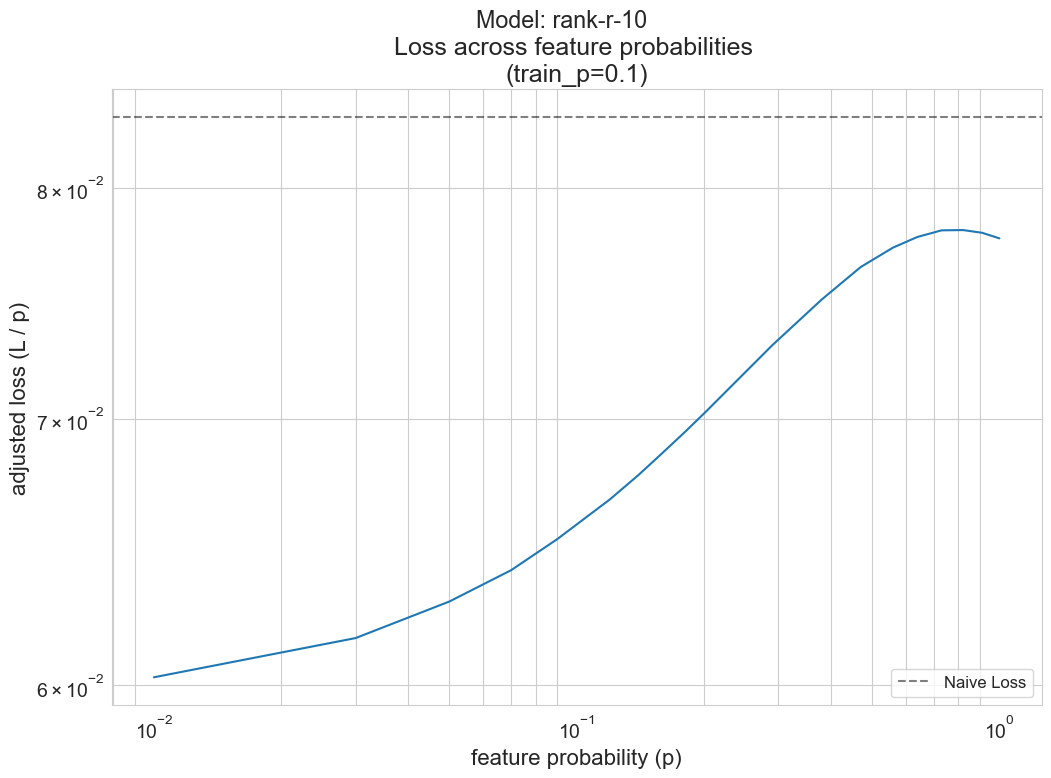

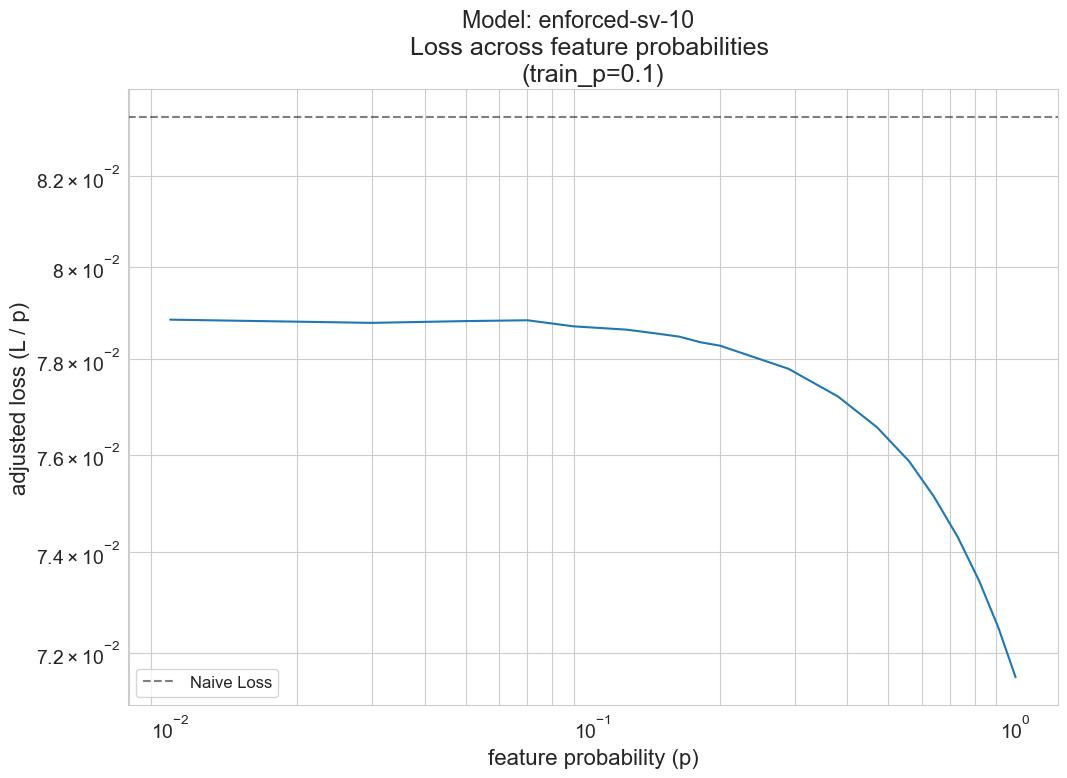

In [ ]:
sparsity_low = np.round(np.linspace(0.0, 0.8, 10), 2)
sparsity_high = np.round(np.linspace(0.8, 0.99, 10), 2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))

for model, name in zip(models, model_names):
    ax, _ = plot.plot_loss_across_sparsities(
        sparsities=sparsities,
        model=model,
        eval_model=eval_model,
        train_sparsity=feat_sparsity,
    )
    ax.figure.suptitle(f"Model: {name}")
    ax.grid(which="both", axis="both")

#### Input-Output


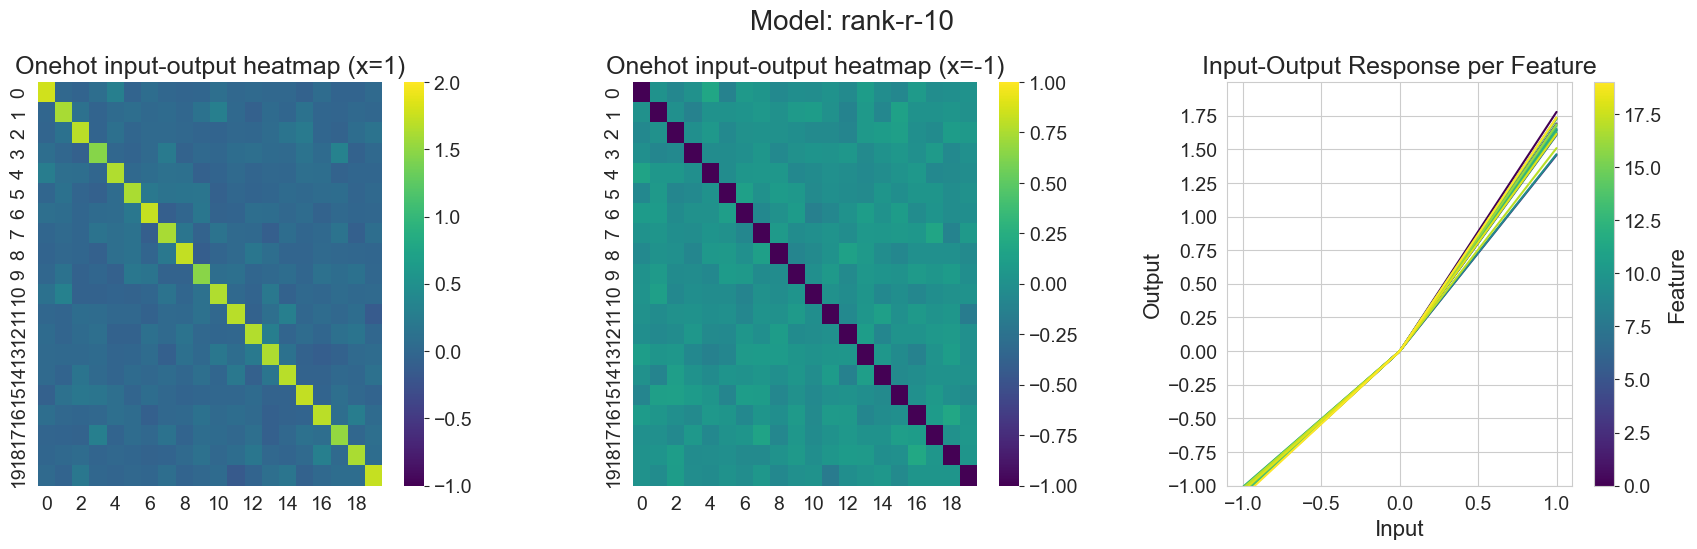

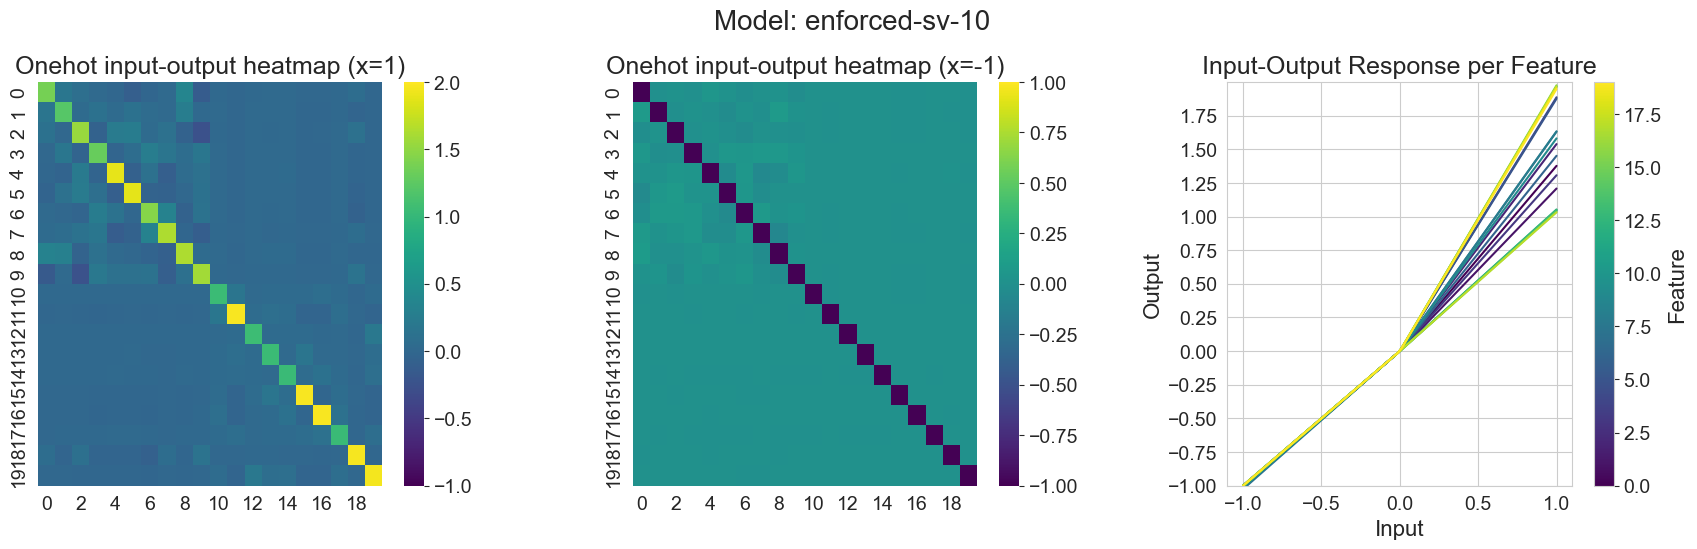

In [ ]:
for model, model_name in zip(models, model_names):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    plot.plot_input_output_heatmap(1, model, ax=axs[0], annot=False, vmax=2)
    plot.plot_input_output_heatmap(-1, model, ax=axs[1], annot=False)
    x = t.linspace(-1, 1, 100, device=device)
    Y = util.in_out_response(model, x, device=device)
    plot.plot_input_output_response(Y, x, list(range(model.cfg.n_feat)), ax=axs[2])
    axs[2].set_ylim(-1, 2)
    axs[2].set_yticks(np.arange(-1, 2, 0.25))

    
    fig.tight_layout(pad=3)
    fig.suptitle(f"Model: {model_name}", fontsize=20)